# Disorder and Fourier Analysis
I will use this notebook to investigate disorder and do Fourier analysis of the critical current vs flux.

The subband Hamiltonian with l = 0 trick in the contacts will be used.

In [84]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import scipy.special
import scipy.integrate
import time
import numpy.fft

In [12]:
%load_ext line_profiler

In [146]:
# create the Hamiltonian matrix

def calc_subband_hamiltonian(params):
    '''
    Returns the Hamiltonian in the real space basis.
    params is a dict with the following information:
        N_z : number of points along z
        t_z : h^2/(2 m a^2), where a is lattice spacing
        t_phi : h^2/(2 m R^2), where a is lattice spacing
        mu : chemical potential
        flux : axial flux in h/e units
        Delta : order parameter
        l : subband index
    '''
    N_z = params['N_z']
    t_z = params['t_z']
    t_phi = params['t_phi']
    mu = params['mu']
    flux = params['flux']
    Delta = params['Delta']
    l = params['l']
  
    mu_e = mu - t_phi*(l - flux)**2
    mu_h = mu - t_phi*(l + flux)**2
    
    def calc_matrix_element(z1,z2):
        '''
        Returns the matrix element between two real space points x and y
        '''
        # onsite element
        if z1 == z2:
            diag_ele = 2*t_z 
            return np.array([[diag_ele - mu_e,Delta],[np.conj(Delta),-diag_ele+mu_h ]])
        # z hopping
        elif abs(z1-z2) == 1:
            return np.array([[-t_z,0],[0,t_z]])
        else:
            return np.array([[0,0],[0,0]])
    
    H_list = [calc_matrix_element(x,y) for x in range(N_z) for y in range(N_z)]
    H = np.array(H_list).reshape((N_z,N_z,2,2))
    
    # magic to flatten the Hamiltonian
    # Are you wathing closely?
    H = np.array([H[x,:,y,:].flatten() for x in range(H.shape[0]) for y in range(H.shape[2])])\
    .flatten().reshape(2*N_z,2*N_z)
    
    return H

# surface Green's funciton routines
# ordinary iteration schemes will be used

def calc_surface_g(E,alpha,beta,eta,eps = 1e-8,max_iter=100000,kappa=0.5):
    '''
    Return the surface Green's function at energy E 
   
    eta is used to calculated the Green's function
    eps controls the accuracy
    
    Returns the surface Green's function as a solution of the recursive relation 
    g = ((E + 1j*eta) - alpha - beta'*g*beta)^-1
    '''
    # conv here to avoid problems later
    E = np.array(E)
    
    
    def func_g(g,E,alpha,beta,eta):
        return np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(alpha.shape[0])- alpha - beta @ g @ np.conj(beta).T)
   
    g0 = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    g = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    
    err_vec = []
    for i in range(max_iter):
        g = func_g(g,E,alpha,beta,eta)
        g = ((1-kappa)*g + kappa*g0)
        err = np.linalg.norm(g - g0)/len(E)
        err_vec.append(err)
        g0 = np.copy(g)
        if err < eps:
            break
    return g

def fermi(E,kT):
    return scipy.special.expit(-E/kT)

# mu is the Fermi level
def generate_fermi_matrix(E,mu,kT):
    return np.array([[[fermi(ele - mu,kT),0],[0,fermi(ele + mu,kT)]] for ele in E])

def calc_sns_negf(E,params):
    '''
    Returns the G,A,Sigma matrices for SNS device. The chemical potential will be assumed to same everywhere and
    no bias is present across the device.
    params dict takes in these parameters:
        N_z : number of points along z in the normal region
        t_z : h^2/(2 m a^2), where a is lattice spacing
        t_phi : h^2/(2 m R^2), where a is lattice spacing
        mu : chemical potential
        Delta_1 : superconducting parameter 1
        Delta_2 : superconducting parameter 2
        eta : imaginary 0+ added for convergence
        flux : axial flux in h/e units
        subband_list : list of subbands to incorporate, the are indexed by angular momentum l
        W : disorder strength
    '''
    N_z = params['N_z']
    t_z = params['t_z']
    t_phi = params['t_phi']
    Delta_1 = params['Delta_1']
    Delta_2 = params['Delta_2']
    mu = params['mu']
    eta = params['eta']
    flux = params['flux']
    kT = params['kT']
    subband_list = params['subband_list']
    W = params['W']
  
    # create alpha/beta hamiltonians for S regions
    # calc surface Green's function
   
    params_S1 = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z, "Delta" : Delta_1, "mu" : mu,"flux" : flux, "l" : 0}
    H_S1 = calc_subband_hamiltonian(params_S1)   
    surface_dof = 2
    alpha_1 = H_S1[:surface_dof,:surface_dof]
    beta_1 = H_S1[:surface_dof,surface_dof:2*surface_dof]
    g_1 = calc_surface_g(E,alpha_1,beta_1,eta)
    
    params_S2 = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z, "Delta" : Delta_2, "mu" : mu,"flux" : flux, "l" : 0}
    H_S2 = calc_subband_hamiltonian(params_S2)   
    surface_dof = 2
    alpha_2 = H_S2[:surface_dof,:surface_dof]
    beta_2 = H_S2[:surface_dof,surface_dof:2*surface_dof]
    g_2 = calc_surface_g(E,alpha_2,beta_2,eta)
   
    I_E_total = np.zeros(len(E))
    dos_total = np.zeros(len(E))
    for l in subband_list:
        # create Hamiltonian for N region
        params_N = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z, "Delta" : 0, "mu" : mu,"flux" : flux, "l" : l}
        # onsite disorder [-W,W]
        H_mat = calc_subband_hamiltonian(params_N) + W*np.diag(2*np.random.rand(2*N_z) - 1)

        #number of dof in a layer
        N_dof_lat = 2
        # the hopping element between layers
        beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]

        # the only non-zero elements in sigma
        sigma_mini_1 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_1@beta_layer
        sigma_mini_2 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_2@beta_layer

        sigma_1 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
        sigma_1[:,:N_dof_lat,:N_dof_lat] = sigma_mini_1
        gamma_1 = 1j*(sigma_1 - np.transpose(np.conj(sigma_1),(0,2,1)))

        sigma_2 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
        sigma_2[:,-N_dof_lat:,-N_dof_lat:] = sigma_mini_2
        gamma_2 = 1j*(sigma_2 - np.transpose(np.conj(sigma_2),(0,2,1)))

        # NEGF matrices
        G = np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2)

        A = 1j*(G - np.transpose(np.conj(G),(0,2,1))) 
        dos = np.real(np.trace(A,axis1=-2,axis2=-1))

        # Fermi level is at E = 0
        F1 = np.kron(np.eye(N_z),generate_fermi_matrix(E,0,kT))
        F2 = np.kron(np.eye(N_z),generate_fermi_matrix(E,0,kT))
        sigma_in = np.matmul(gamma_1,F1) + np.matmul(gamma_2,F2)

        G_n = np.matmul(G,np.matmul(sigma_in,np.transpose(np.conj(G),(0,2,1))))

        I_mat = 1j*(np.matmul(H_mat,G_n) - np.matmul(G_n,H_mat))
        # current = electron current - hole current
        I = np.real(np.trace(I_mat[:,0:2:2,0:2:2]-I_mat[:,1:2:2,1:2:2],axis1=-1,axis2=-2))
        
        I_E_total += I
        dos_total += dos

    return dos_total,I_E_total

def integrate_current(E_vec,I_vec):
    return scipy.integrate.simps(I_vec,E_vec) 

def calc_I_phi(E_vec,phi_vec,params):
    I_phi = []
    for phi in phi_vec:
        params['Delta_2'] = params['Delta_1']*np.exp(1j*phi)
        dos,I = calc_sns_negf(E_vec,params)
        I_phi.append(integrate_current(E_vec,I))
    I_phi = np.array(I_phi)
    return I_phi

def calc_I_flux(E_vec,phi_vec,flux_vec,params):
    '''
    Calculates current as a function of flux and phase difference
    The current is integrated over the E_vec grid.
    '''
    I_array = []
    for flux in flux_vec:
        params['flux'] = flux
        I_array.append(calc_I_phi(E_vec,phi_vec,params))
    return np.array(I_array)

def calc_critical_current(phi_vec,I_array):
    '''
    Returns the critical current value given I(phi) 
    Also returns the critical phase
    '''
    arg_max = np.argmax(I_array,axis = 1)
    I_c = I_array[:,arg_max]
    return I_c,phi_vec[arg_max]

# Tests

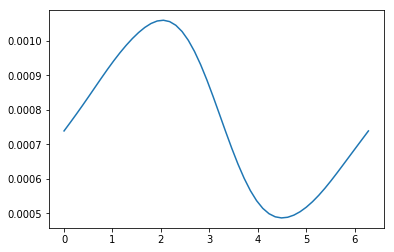

In [59]:
# current-phase
params = {
    "N_z" : 20,
    "t_z" : 5e-3,
    "t_phi" : 2e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 20e-3,
    "flux" : 0.0,
    "kT" : 1e-5
}

params["subband_list"] = [-1,0,1]

E_vec = np.linspace(-2e-3,2e-3,50)
phi_vec = np.linspace(0,2*np.pi,50)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

#I_phi = calc_I_phi(E_vec,phi_vec,params)
%lprun -f calc_sns_negf I_phi = calc_I_phi(E_vec,phi_vec,params)
plt.plot(phi_vec,I_phi)

In [101]:
print("Length",params['N_z']*np.sqrt(1.7/params['t_z']))
print("Depopulation flux",abs(np.sqrt(params['mu']/params['t_phi']) - max(params['subband_list'])))

Length 184.39088914585773
Depopulation flux 2.1622776601683795


In [61]:
def calc_omega(l,flux,params):
    L = params['N_z']*np.sqrt(1.7/params['t_z'])
    healing_length = 1.287*np.sqrt(params['mu'] - params['t_phi']*(l**2 + flux**2))/(2*abs(params['Delta_1']))
    return (L/healing_length)*(2*params['t_phi']*l/abs(params['Delta_1']))

Text(0,0.5,'semiclassical period')

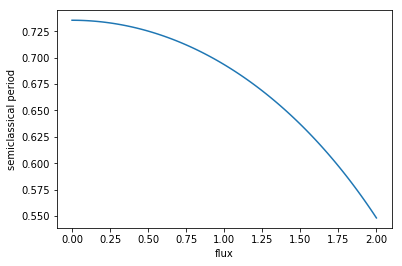

In [99]:
flux_vec = np.linspace(0,2,100)
omega_vec = calc_omega(1,flux_vec,params)
plt.plot(flux_vec,2*np.pi/omega_vec)
plt.xlabel("flux")
plt.ylabel("semiclassical period")

# Fourier Spectrum Study

In [124]:
# Critical current
# current-phase
params = {
    "N_z" : 40,
    "t_z" : 20e-3,
    "t_phi" : 2e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 20e-3,
    "kT" : 1e-5
}

params["subband_list"] = [-1,0,1]

E_vec = np.linspace(-2e-3,2e-3,50)
phi_vec = np.linspace(0,2*np.pi,50)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

flux_vec = np.linspace(0,2,100)
%lprun -f calc_sns_negf I_array_2 = calc_I_flux(E_vec,phi_vec,flux_vec,params)

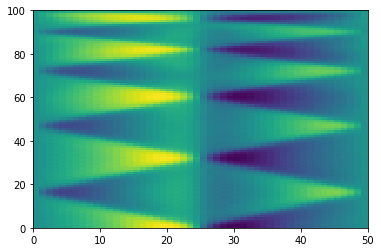

In [125]:
plt.pcolor(I_array_2)

Text(0,0.5,'Critical Current')

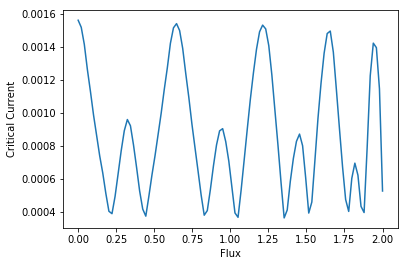

In [128]:
plt.plot(flux_vec,np.max(I_array_2,axis=1))
plt.xlabel("Flux")
plt.ylabel("Critical Current")

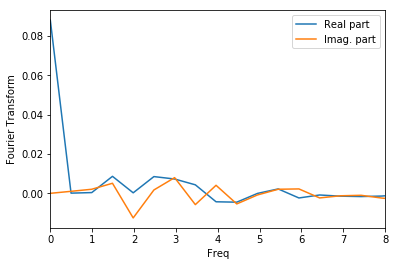

In [132]:
signal = np.max(I_array_2,axis=1)
fourier = np.fft.rfft(signal)
freq = np.fft.rfftfreq(len(signal),flux_vec[1]-flux_vec[0])
plt.plot(freq,np.real(fourier),label="Real part")
plt.plot(freq,np.imag(fourier),label="Imag. part")
plt.xlim([0,8])
plt.xlabel("Freq")
plt.ylabel("Fourier Transform")
plt.legend()

Text(0,0.5,'Fourier Transform')

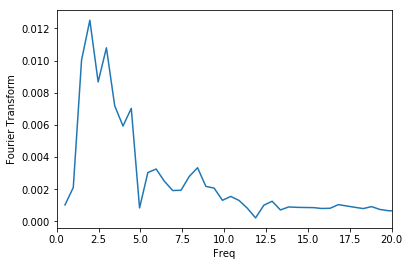

In [137]:
plt.plot(freq[1:],np.abs(fourier)[1:])
plt.xlim([0,20])
plt.xlabel("Freq")
plt.ylabel("Fourier Transform")

Text(0,0.5,'Fourier Transform')

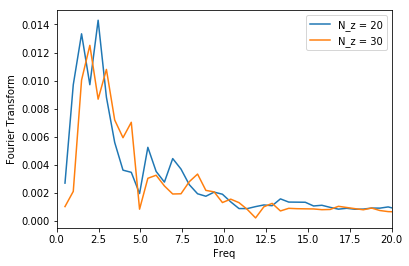

In [142]:
signal = np.max(I_array,axis=1)
signal_2 = np.max(I_array_2,axis=1)
fourier = np.fft.rfft(signal)
fourier_2 = np.fft.rfft(signal_2)
plt.plot(freq[1:],np.abs(fourier)[1:],label="N_z = 20")
plt.plot(freq[1:],np.abs(fourier_2)[1:],label="N_z = 30")
plt.xlim([0,20])
plt.legend()
plt.xlabel("Freq")
plt.ylabel("Fourier Transform")

# Disorder Study

In [160]:
params = {
    "N_z" : 30,
    "t_z" : 20e-3,
    "t_phi" : 2e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 20e-3,
    "kT" : 1e-5
}

params["subband_list"] = [-1,0,1]

E_vec = np.linspace(-2e-3,2e-3,50)
phi_vec = np.linspace(0,2*np.pi,50)
params['eta'] = np.abs(E_vec[1] - E_vec[0])
flux_vec = np.linspace(0,2,100)

W_vec = [1e-3,2e-3,4e-3,8e-3,16e-3]
I_array_list = []
for W in W_vec:
    params['W'] = W
    print(W)
    I_array_list.append(calc_I_flux(E_vec,phi_vec,flux_vec,params))

0.001
0.002
0.004
0.008
0.016


Text(0.5,1,'Effect on Onsite Disorder')

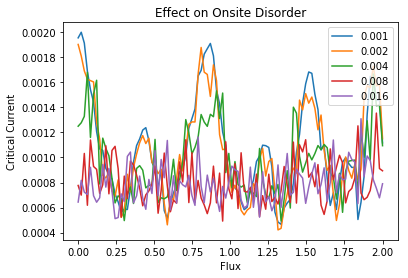

In [166]:
for ele in I_array_list:
    plt.plot(flux_vec,np.max(ele,axis=1))
plt.legend(W_vec)    
plt.xlabel("Flux")
plt.ylabel("Critical Current")
plt.title("Effect on Onsite Disorder")